In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing
import persim

In [2]:
stepsize, PP, bw = 3,6,10
ndims = 3

nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
wsrc = '../cell_dams/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(transcriptomes == TT[i])[0][0] for i in range(len(TT))])

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wall[tf.imread(nsrc + sample + '_EDT.tif') < 2] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[ focus['Bact'] == 'Infected' ]
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values

metafocus = metafocus.astype(int)
isnuclei = (metacell.loc[metafocus[:,0], 'nuclei_area'] > 0).values
transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0], 'ndimage_cellID'].values.astype(str)]

zvals = np.empty((0), dtype=float)
for j in range(len(tidxs)):
    zvals = np.hstack((zvals, (tlocs.iloc[ tcumsum[tidxs[j]]:tcumsum[tidxs[j] + 1] , -1].values)))
zvmin,zvmax = np.quantile(zvals, [0.05,0.95])
zbins = np.linspace(zvmin, zvmax, 10)

(968, 5)


In [3]:
level = 'sup'
normtype='gene'

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep
dsrc = '../distance/'
dsrc += '{}/{}_vs_{}_{}/'.format(sample, *transcriptomes[tidxs], normtype)

dst = '../animation/'
dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)
adst = dst + '{}_vs_{}_-_{}level_{}'.format(*transcriptomes[tidxs], level, normtype) + os.sep
print(adst)
if not os.path.isdir(adst):
    os.mkdir(adst)

if   normtype == 'both':
    ratios = transfocus.values/np.sum(transfocus.values, axis=None)
elif normtype == 'cell':
    ratios = transfocus.values/np.sum(transfocus.values, axis=0)
elif normtype == 'gene':
    ratios = transfocus.values/np.sum(transfocus.values, axis=1).reshape(-1,1)

print('Max ratio:\t', 100*np.max(ratios), '%')
transfocus

../animation/D2/GLYMA_05G092200_vs_GLYMA_17G195900_-_suplevel_gene/
Max ratio:	 0.48656617926518064 %


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
26,249,317,581,307,195,1026,529,686,340,694,...,438,406,187,183,271,241,62,152,396,806
85,363,1239,1022,572,933,1182,531,1808,975,1305,...,228,156,48,62,107,131,49,86,138,371


../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/GLYMA_05G092200_vs_GLYMA_17G195900_gene_suplevel_bottleneck_00000_00400.csv
../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/GLYMA_05G092200_vs_GLYMA_17G195900_gene_suplevel_bottleneck_00400_01000.csv
../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/GLYMA_05G092200_vs_GLYMA_17G195900_gene_suplevel_bottleneck_01000_01936.csv


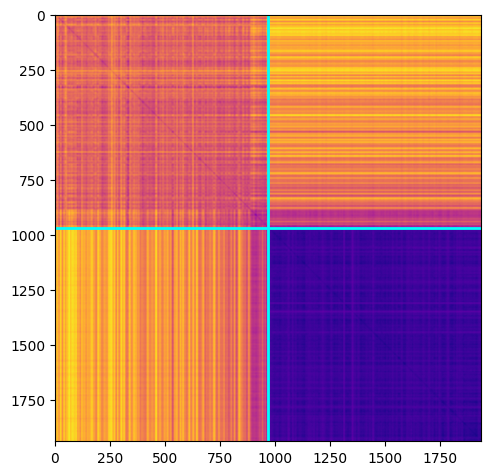

In [4]:
isdiag = np.loadtxt(dsrc + '{}level_bottleneck_isdiagonal.csv'.format(level), delimiter=',', dtype=bool)

filenames = sorted(glob(dsrc + '*{}_{}level_bottleneck_*.csv'.format(normtype, level)))
print(*filenames, sep='\n')
NN = int(os.path.splitext(filenames[-1])[0].split('_')[-2:][-1])
   
bottleneck = np.zeros((NN,NN))

for i in range(len(filenames)):
    foo = os.path.splitext(filenames[i])[0].split('_')[-2:]
    slic = np.s_[ int(foo[0]) : int(foo[1])]
    bottleneck[slic] = np.loadtxt(filenames[i], delimiter=',')

bottleneck += bottleneck.T

img = bottleneck.copy().astype(np.uint8)
img = ndimage.uniform_filter(img, size=9, mode='reflect')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(img, cmap='plasma')
ax[i].axhline(transfocus.shape[1], c='cyan', lw=2)
ax[i].axvline(transfocus.shape[1], c='cyan', lw=2)

fig.tight_layout();

In [5]:
mds_params = {'n_components':2, 'metric':True, 'random_state':42, 'dissimilarity':'precomputed', 'normalized_stress':False}
filename = dsrc + 'mds_{}_{}level_bottleneck.csv'.format(normtype, level)
if not os.path.isfile(filename):
    mds = manifold.MDS(**mds_params).fit_transform(bottleneck)
    pd.DataFrame(mds, columns=['x','y']).to_csv(filename, index = False)

mds = pd.read_csv(filename)
mds['gene'] = np.repeat(transcriptomes[tidxs], len(focus))
mds['cell.ID'] = np.tile(focus['Cell.ID..'].values, len(tidxs))

mx, Mx = mds['x'].min(), mds['x'].max()
my, My = mds['y'].min(), mds['y'].max()

mds.head()

,x,y,gene,cell.ID
0,-29.731586,-21.161243,GLYMA_05G092200,743
1,-21.434876,27.241306,GLYMA_05G092200,843
2,-35.996845,22.711790,GLYMA_05G092200,2053
3,-5.669490,16.010099,GLYMA_05G092200,1146
4,7.963405,18.168858,GLYMA_05G092200,896


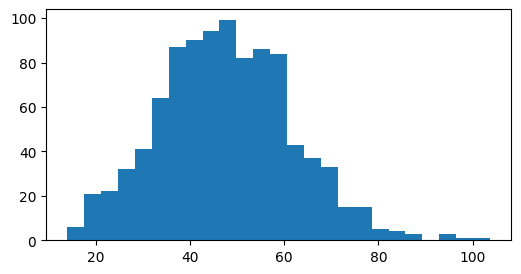

In [6]:
diff = np.zeros(len(focus))
for j in range(len(diff)):
    diff[j] = bottleneck[j, j+len(focus)]

dmin, dmax = np.quantile(diff, [0.025, 0.975])
sdiff = np.argsort(diff)
rdiff = np.argsort(sdiff)
pd.Series(diff).describe()

fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(diff, bins=25);

In [7]:
kidx = len(diff) - 1
k = sdiff[kidx]
cidx = metafocus[k,0]
print(k, cidx, sep='\t')

PP = 10
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

pxs = 75
cell[ -15:-5, 5:5 + pxs] = 0

12	2063


In [8]:
import matplotlib.lines as mlines
diagm = mlines.Line2D([], [], mfc="#932667FF", marker='o', ls='None', mec='k', mew=2, ms=10)
nondiagm = mlines.Line2D([], [], mfc="#932667FF", marker='D', ls='None', mec='gray', mew=2, ms=10)

redc = mlines.Line2D([], [], mfc="red", marker='o', ls='None', mec='k', mew=2, ms=10)
blued = mlines.Line2D([], [], mfc="cornflowerblue", marker='D', ls='None', mec='k', mew=2, ms=10)

cm = plt.colormaps['inferno']
dbins = np.linspace(diff.min(), diff.max(), 30)

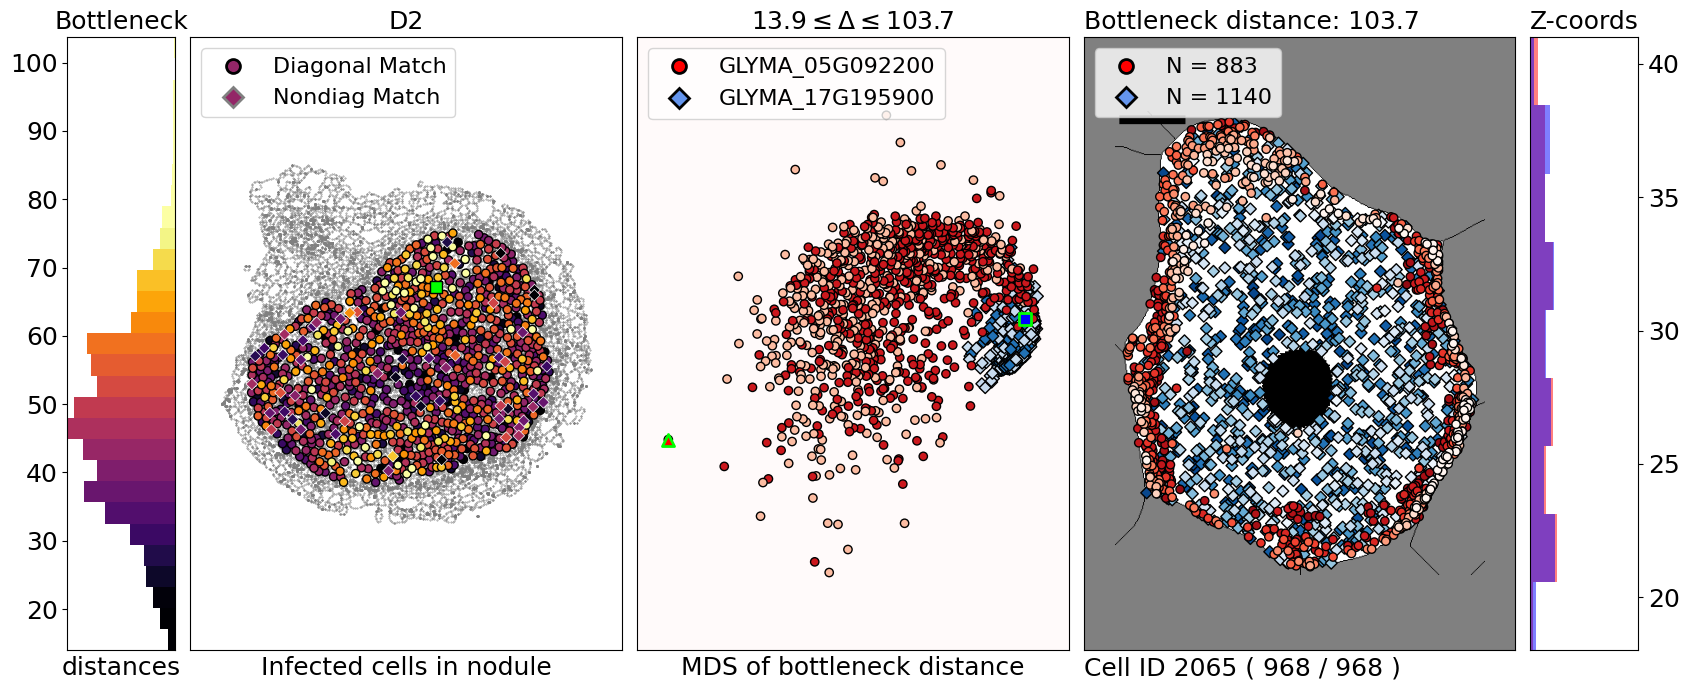

In [13]:
cmap = ['Reds_r', 'Blues_r']; shape = ['o', 'D', '^', 's']; color=['red', 'blue']

fs = 18; s=35

krange = sdiff[:kidx+1]
drange = isdiag[krange]

fig, ax = plt.subplots(1,5, figsize=(17,7), width_ratios=[1,4,4,4,1])
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].hist(diff, bins=dbins, orientation='horizontal', zorder=1, color='lightgray')
n, _, patches = ax[i].hist(diff[krange], bins=dbins, orientation='horizontal', zorder=2)
bin_centers = 0.5 * (dbins[:-1] + dbins[1:])
bin_centers[bin_centers < dmin] = dmin
bin_centers[bin_centers > dmax] = dmax

col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches.patches):
    p.set_facecolor(cm(c))
ax[i].invert_xaxis();

i = 1
ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)

ax[i].scatter(metafocus[krange,13][drange], metafocus[krange,14][drange], c=diff[krange][drange], vmin=dmin, vmax=dmax,
              s=s, cmap='inferno', marker='o', edgecolor='k', linewidth=1, label='Diagonal match', zorder=2);
ax[i].scatter(metafocus[krange,13][~drange], metafocus[krange,14][~drange], c=diff[krange][~drange], vmin=dmin, vmax=dmax,
              s=s, cmap='inferno', marker='D', edgecolor='white', linewidth=0.5, label='Nondiag match', zorder=3); 

ax[i].scatter(metafocus[k,13], metafocus[k,14], c='lime', s = 75,
              marker='s', edgecolor='k', linewidth=1, zorder=4); i+=1

for j in range(len(tidxs)):
    foo = mds[mds['gene'] == transcriptomes[tidxs[j]]].loc[:, ['x','y']].iloc[krange]
    ax[i].scatter(foo['x'], foo['y'], c=2*isnuclei[krange], cmap=cmap[j], marker=shape[j], alpha=1,vmin=-1, vmax=3,
                 edgecolor='k', linewidth=1, label=transcriptomes[tidxs[j]], zorder=len(tidxs)+1-j)
    ax[i].scatter(foo.iloc[-1,0], foo.iloc[-1,1], c=color[j], marker=shape[j+2], s = 75,
                 edgecolor='lime', linewidth=2, zorder=len(tidxs)+5-j)

ax[i].scatter([mx, Mx], [my, My], color='snow')
ax[i].set_facecolor('snow'); i += 1

ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
ax[i].set_facecolor('#808080')

foo = [3,4]
for j in range(len(tidxs)):
    coords = translocs[tidxs[j]].values.T
    cmask = label[ coords[1], coords[0] ] == cidx + 1
    ccoords = coords[:, cmask ].copy()
    zlevel = ccoords[2]
    foo[j] = len(ccoords[0])
    ax[i].scatter(ccoords[0], ccoords[1], c=ccoords[2], cmap=cmap[j], marker=shape[j], zorder=5-j, alpha=1, 
                  vmin=zvmin, vmax=zvmax, edgecolor='k', label='N = {}'.format(len(ccoords[0])));
    ax[i+1].hist(ccoords[2], bins=zbins, orientation='horizontal', color=color[j], alpha=0.5, density=True)
    ax[i+1].scatter([0.3], [30], alpha=0)

ax[-1].yaxis.tick_right()

ax[1].legend([diagm, nondiagm], ['Diagonal Match','Nondiag Match'], fontsize=fs-2, markerscale=1, loc='upper left')
ax[2].legend([redc, blued], transcriptomes[tidxs], fontsize=fs-2, markerscale=1, loc='upper left')
ax[3].legend([redc, blued], ['N = {}'.format(bar) for bar in foo], fontsize=fs-2, markerscale=1, loc='upper left')

for i in range(1,4):
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

for i in range(len(ax)):
    ax[i].margins(0)

ax[1].set_title(sample, fontsize=fs)
ax[2].set_title('${:.1f} \leq \Delta \leq {:.1f}$'.format(diff.min(), diff.max()), fontsize=fs)
ax[3].set_title('Bottleneck distance: {:.1f}'.format(diff[k]), loc='left', fontsize=fs)

for i in [0,-1]:
    ax[i].tick_params(bottom=False, labelbottom=False, labelsize=fs)

ax[0].set_title('Bottleneck', fontsize=fs)
ax[0].set_xlabel('distances', fontsize=fs)
ax[1].set_xlabel('Infected cells in nodule', fontsize=fs)
ax[2].set_xlabel('MDS of bottleneck distance', fontsize=fs)
ax[3].set_xlabel('Cell ID {:04d} ( {:03d} / {:03d} )'.format(metacell.loc[cidx, 'orig_cellID'], kidx+1, len(diff)), loc='left', fontsize=fs)
ax[4].set_title('Z-coords', fontsize=fs)

fig.tight_layout()

filename = adst + '{}_vs_{}_-_{}level_{}_{:05d}'.format(*transcriptomes[tidxs], level, normtype, kidx)
plt.savefig(filename+'.png', format='png', bbox_inches='tight', dpi=250)
plt.savefig(filename+'.pdf', format='pdf', bbox_inches='tight', dpi=250)

In [12]:
filename

'../animation/D2/GLYMA_05G092200_vs_GLYMA_17G195900_-_suplevel_gene/GLYMA_05G092200_vs_GLYMA_17G195900_-_suplevel_gene_00967'

In [168]:
diff[np.nonzero(~isdiag)[0]]

array([33.18372393, 30.12898882, 51.44862057, 36.92231487, 43.07220046,
       31.86002074, 26.12916366, 33.88359551, 38.14868314, 49.52418296,
       56.83251194, 38.38978939, 40.75594249, 38.35748734, 58.60327993,
       30.19934673, 28.59582762, 44.91663425, 30.69295382, 37.71287412,
       41.57447509, 28.74905699, 45.22901378, 31.11073174, 37.28501612,
       20.66164302, 41.44096089, 52.43110245, 32.32448088, 34.56968555,
       23.75590477, 51.64851696, 45.97924924, 23.41115285, 51.47016523,
       68.87488948, 53.06918802, 36.8374998 , 34.2638484 , 43.83400926,
       41.48009975, 62.39884151, 36.50637852, 16.59560091, 33.21909368,
       31.16562463, 53.91977394, 37.74716389, 49.43726386, 27.59833193,
       24.41770467, 13.93580905, 24.27690387, 39.90743215, 20.6590227 ])

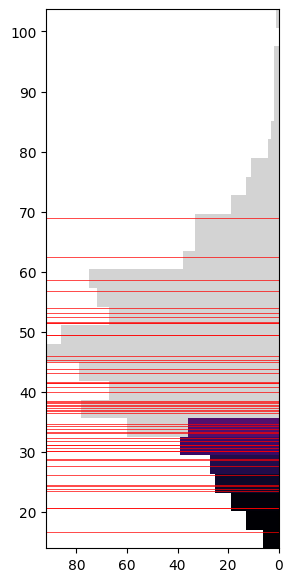

In [171]:
fig, ax = plt.subplots(1,1, figsize=(3,7))
ax = np.atleast_1d(ax).ravel(); i = 0

# Plot histogram.
ax[i].hist(diff, bins=dbins, orientation='horizontal', zorder=1, color='lightgray')
n, _, patches = ax[i].hist(diff[krange], bins=dbins, orientation='horizontal', zorder=2)
bin_centers = 0.5 * (dbins[:-1] + dbins[1:])
bin_centers[bin_centers < dmin] = dmin
bin_centers[bin_centers > dmax] = dmax

col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches.patches):
    p.set_facecolor(cm(c))

for v in diff[np.nonzero(~isdiag)[0]]:
    ax[i].axhline(v, c='red', lw=0.5)

ax[i].margins(0);
ax[i].invert_xaxis();

In [22]:
kidx = 480
for kidx in range(len(sdiff)):
    k = sdiff[kidx]
    cidx = metafocus[k,0]
    print(k, cidx, sep='\t')
    
    PP = 10
    ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
          np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
    extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
    cell = wall[ss].copy().astype(np.uint8)
    cell[ label[ss] == cidx+1 ] = 2
    cell[~wall[ss]] = 0
    
    pxs = 75
    cell[ -15:-5, 5:5 + pxs] = 0
    
    krange = sdiff[:kidx+1]
    
    fig, ax = plt.subplots(1,4, figsize=(14,5))
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
    ax[i].scatter(metafocus[krange,13], metafocus[krange,14], c=diff[krange], vmin=dmin, vmax=dmax,
                  cmap='inferno', marker='o', edgecolor='k', linewidth=1, label='Infected', zorder=2); 
    ax[i].scatter(metafocus[k,13], metafocus[k,14], c='lime', s = 75,
                  marker='s', edgecolor='k', linewidth=1, zorder=3); i+=1
    
    for j in range(len(tidxs)):
        foo = mds[mds['gene'] == transcriptomes[tidxs[j]]].loc[:, ['x','y']].iloc[krange]
        ax[i].scatter(foo['x'], foo['y'], c=diff[krange], cmap=cmap[j], marker=shape[j], alpha=1,vmin=dmin, vmax=dmax,
                     edgecolor='k', linewidth=1, label=transcriptomes[tidxs[j]], zorder=len(tidxs)+1-j)
        ax[i].scatter(foo.iloc[-1,0], foo.iloc[-1,1], c='lime', marker='s', s = 75,
                     edgecolor='k', linewidth=1, zorder=len(tidxs)+5-j)
    
    ax[i].scatter([mx, Mx], [my, My], color='snow')
    ax[i].set_facecolor('snow'); i += 1
    
    ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
    ax[i].set_facecolor('#808080')
    if True:
        for j in range(len(tidxs)):
            coords = translocs[tidxs[j]].values.T
            cmask = label[ coords[1], coords[0] ] == cidx + 1
            ccoords = coords[:, cmask ].copy()
            zlevel = ccoords[2]
            ax[i].scatter(ccoords[0], ccoords[1], c=ccoords[2], cmap=cmap[j], marker=shape[j], zorder=5-j, alpha=1, 
                          vmin=zvmin, vmax=zvmax, edgecolor='k', label='N = {}'.format(len(ccoords[0])));
            ax[i+1].hist(ccoords[2], bins=zbins, orientation='horizontal', color=color[j], alpha=0.75, density=True)
            ax[i+1].scatter([0.15], [30], alpha=0)
    
    for i in range(len(ax)-1):
        ax[i].legend(fontsize=fs-4, markerscale=2, loc='lower left');
        ax[i].set_aspect('equal', 'datalim')
        ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    
    #ax[-1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[0].set_title(sample, fontsize=fs)
    ax[1].set_title('${:.1f} \leq \Delta \leq {:.1f}$'.format(diff.min(), diff.max()), fontsize=fs)
    ax[2].set_title('Bottleneck distance: {:.1f}'.format(diff[k]), loc='left', fontsize=fs)
    
    ax[0].set_xlabel('Bottleneck distances', fontsize=fs)
    ax[1].set_xlabel('MDS of bottleneck distance', fontsize=fs)
    ax[2].set_xlabel('Cell ID {:04d} ( {:03d} / {:03d} )'.format(metacell.loc[cidx, 'orig_cellID'], kidx+1, len(diff)), loc='left', fontsize=fs)
    
    fig.tight_layout()
    
    filename = adst + '{}_vs_{}_-_{}level_{}_{:05d}.png'.format(*transcriptomes[tidxs], level, normtype, kidx)
    plt.savefig(filename, format='png', bbox_inches='tight', dpi=72)
    plt.close()

911	2058
487	885
905	2152
624	2249
850	1101
777	1983
463	1188
920	484
372	1580
924	1657
958	302
406	577
931	824
918	1423
693	1690
690	948
807	2514
932	1156
828	385
947	1872
681	756
964	2429
531	372
963	1453
737	1578
959	1781
796	914
903	2461
806	1042
277	374
783	1216
666	473
870	1435
919	1186
791	1501
960	1723
895	1063
965	1142
276	686
614	1150
142	1402
788	1546
603	866
713	2086
886	1902
782	1039
922	794
821	607
904	837
872	729
535	882
187	950
934	565
902	1233
906	396
899	1206
955	1438
915	1417
597	307
51	1158
117	1352
867	1478
961	1570
325	928
662	941
945	2012
771	578
897	2309
938	2308
864	551
935	601
824	495
584	1855
677	2193
891	786
825	1077
894	2522
822	1937
890	1672
948	1936
123	946
951	2423
313	726
708	674
428	1377
946	2160
528	452
491	1502
772	831
790	1205
898	1791
619	896
4	895
940	1932
375	1221
695	826
209	1005
925	1851
183	1047
34	953
307	917
294	1387
412	722
192	580
887	571
343	1359
939	1928
113	489
261	1495
794	926
473	1248
893	1307
819	805
637	2283
913	2195
508	1725
268	54

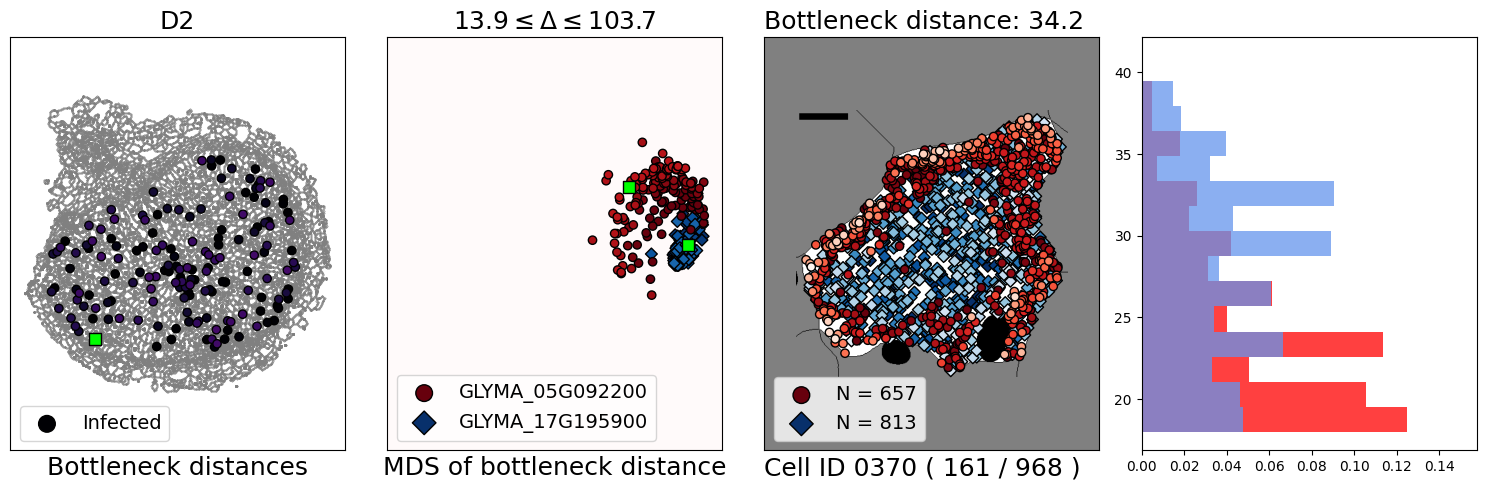

In [14]:
cmap = ['Reds_r', 'Blues_r']; shape = ['o', 'D']; color=['red','cornflowerblue']
fs = 18

krange = sdiff[:kidx+1]

fig, ax = plt.subplots(1,4, figsize=(15,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(metafocus[krange,13], metafocus[krange,14], c=diff[krange], vmin=dmin, vmax=dmax,
              cmap='inferno', marker='o', edgecolor='k', linewidth=1, label='Infected', zorder=2); 
ax[i].scatter(metafocus[k,13], metafocus[k,14], c='lime', s = 75,
              marker='s', edgecolor='k', linewidth=1, zorder=3); i+=1

for j in range(len(tidxs)):
    foo = mds[mds['gene'] == transcriptomes[tidxs[j]]].loc[:, ['x','y']].iloc[krange]
    ax[i].scatter(foo['x'], foo['y'], c=diff[krange], cmap=cmap[j], marker=shape[j], alpha=1,vmin=dmin, vmax=dmax,
                 edgecolor='k', linewidth=1, label=transcriptomes[tidxs[j]], zorder=len(tidxs)+1-j)
    ax[i].scatter(foo.iloc[-1,0], foo.iloc[-1,1], c='lime', marker='s', alpha=1, s = 75,
                 edgecolor='k', linewidth=1, zorder=len(tidxs)+5-j)

ax[i].scatter([mx, Mx], [my, My], color='snow')
ax[i].set_facecolor('snow'); i += 1

ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
ax[i].set_facecolor('#808080')
if True:
    for j in range(len(tidxs)):
        coords = translocs[tidxs[j]].values.T
        cmask = label[ coords[1], coords[0] ] == cidx + 1
        ccoords = coords[:, cmask ].copy()
        zlevel = ccoords[2]
        ax[i].scatter(ccoords[0], ccoords[1], c=ccoords[2], cmap=cmap[j], marker=shape[j], zorder=5-j, alpha=1, 
                      vmin=zvmin, vmax=zvmax, edgecolor='k', label='N = {}'.format(len(ccoords[0])));
        ax[i+1].hist(ccoords[2], bins=zbins, orientation='horizontal', color=color[j], alpha=0.75, density=True)
        ax[i+1].scatter([0.15], [30], alpha=0)
        
for i in range(len(ax)-1):
    ax[i].legend(fontsize=fs-4, markerscale=2, loc='lower left');
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

ax[0].set_title(sample, fontsize=fs)
ax[1].set_title('${:.1f} \leq \Delta \leq {:.1f}$'.format(diff.min(), diff.max()), fontsize=fs)
ax[2].set_title('Bottleneck distance: {:.1f}'.format(diff[k]), loc='left', fontsize=fs)

ax[0].set_xlabel('Bottleneck distances', fontsize=fs)
ax[1].set_xlabel('MDS of bottleneck distance', fontsize=fs)
ax[2].set_xlabel('Cell ID {:04d} ( {:03d} / {:03d} )'.format(metacell.loc[cidx, 'orig_cellID'], kidx+1, len(diff)), loc='left', fontsize=fs)

fig.tight_layout()